Our first job is to create a tf-idf vector for each document.

In [1]:
import os
from glob import glob
result = [y for x in os.walk("../raw/processed") for y in glob(os.path.join(x[0], '*.txt'))]
print(result[0])

../raw/processed\0103DOM.zip\logFechamento.txt


In [2]:
# remove all files called "logFechamento.txt"
list_of_files = [item for item in result if not item.endswith("logFechamento.txt")]
print(list_of_files[0])

../raw/processed\0103DOM.zip\AACAADM.0\Publicacao\AACAADM.0839.txt


In [3]:
# The text files are recorded with arbitrary encoding, so we need to cater for that.
import io

def read_hostile_text(path_txt):
    encodings = [
        'utf-8',
        'latin_1',
        'utf_16',
        'cp1250',
    ]
    for encoding in encodings:
        file = io.open(path_txt, "r", encoding=encoding)
        try:
            text = file.read()
            file.close()
            return text
        except UnicodeDecodeError:
            file.close()
    print('Could not decode', path_txt)
    return None

In [4]:
text = read_hostile_text(list_of_files[0])
print(text)

010306 Publicacao 


((TITULO))DECRETO  Nº 56.839,  DE  29  DE  FEVEREIRO  DE  2016
((EMENTA))Institui o Comitê Intersecretarial do Circuito das Compras da Cidade de São Paulo  Comitê SPCircuito das Compras; atribui incumbências à Secretaria Municipal do Desenvolvimento, Trabalho e Empreendedorismo; transfere os cargos de provimento em comissão que especifica.
((TEXTO))FERNANDO HADDAD, Prefeito do Município de São Paulo, no uso das atribuições que lhe são conferidas por lei,
D E C R E T A:
Art. 1º Fica instituído o Comitê Intersecretarial do Circuito das Compras da Cidade de São Paulo  Comitê SPCircuito das Compras, com a incumbência de realizar o acompanhamento do contrato celebrado entre a Prefeitura do Município de São Paulo, por meio da Secretaria Municipal do Desenvolvimento, Trabalho e Empreendedorismo, e o Consórcio Circuito SP, vencedor da Concorrência Pública nº 01-B/SDTE/2014.
Art. 2º O Comitê SPCircuito das Compras será composto pelos Secretários das seguintes Pastas:
I

In [5]:
# For each file in that list, extract the document and put it in the documents list.
documents = []
for filename in list_of_files:
  documents.append(read_hostile_text(filename))

The documents are very poluted, with many numbers, which will end up being interpreted as tokens, where they don't really add
any semantic value. So we'll filter those out.

In [65]:
def token_is_valid(token):
    return (not token.isdigit()) and ('__' not in token) and ('((' not in token) and ('\n' not in token)

In [66]:
# This assumes that the separator is a space (' '), which will not always be the case...
# TODO deal with colons, semicolons, \x96, brackets
# TODO deal with the special case where a word is spelled with spaces between each letter (e.g. 'D E C R E T A')
documents = [''.join([token for token in document if token_is_valid(token)]) for document in documents]

In [67]:
documents[0]

' Publicacao ((TITULO))DECRETO  Nº .,  DE    DE  FEVEREIRO  DE  ((EMENTA))Institui o Comitê Intersecretarial do Circuito das Compras da Cidade de São Paulo \x96 Comitê SP\x96Circuito das Compras; atribui incumbências à Secretaria Municipal do Desenvolvimento, Trabalho e Empreendedorismo; transfere os cargos de provimento em comissão que especifica.((TEXTO))FERNANDO HADDAD, Prefeito do Município de São Paulo, no uso das atribuições que lhe são conferidas por lei,D E C R E T A:Art. º Fica instituído o Comitê Intersecretarial do Circuito das Compras da Cidade de São Paulo \x96 Comitê SP\x96Circuito das Compras, com a incumbência de realizar o acompanhamento do contrato celebrado entre a Prefeitura do Município de São Paulo, por meio da Secretaria Municipal do Desenvolvimento, Trabalho e Empreendedorismo, e o Consórcio Circuito SP, vencedor da Concorrência Pública nº -B/SDTE/.Art. º O Comitê SP\x96Circuito das Compras será composto pelos Secretários das seguintes Pastas:I \x96 Secretaria M

We now need to calculate a TF-IDF dictionary for each document. This will be a sparse dictionary.

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1)
tfidf = vectorizer.fit_transform(documents)

In [69]:
vectorizer.vocabulary_

{'dellai': 97553,
 'horassolange': 172313,
 'confirmadolook': 79820,
 'picinini': 277022,
 'acasalamento': 2648,
 'mdbr': 229321,
 'suplentemarcileia': 345041,
 'smrgfábio': 333011,
 'espontao': 127420,
 'marniê': 225161,
 'vasconcelospara': 368490,
 'spartaco': 338648,
 'perissini': 274478,
 'limpocomunicado': 212730,
 'leonor': 208932,
 'restritivos': 304154,
 'nortecristina': 251855,
 'passeiorenato': 268213,
 'lestevania': 209701,
 'chiulli': 65816,
 'autorizaçãoespacho': 31888,
 'atsi': 30150,
 'annapurna': 18621,
 'organizadosjustificativa': 260204,
 'suarella': 341656,
 'huletia': 174602,
 'abandonoprocessos': 1131,
 'danfercoronel': 93529,
 'zafolon': 380670,
 'panese': 264656,
 'caxe': 60539,
 'piritubaeunice': 278504,
 'pondorf': 281973,
 'racialluiz': 294572,
 'relatorial': 301234,
 'glecia': 156647,
 'menorcnpj': 231822,
 'kunz': 203927,
 'comag': 75863,
 'tinentes': 354541,
 'coletorakoto': 74100,
 'anjosnº': 18579,
 'slq': 329925,
 'apost': 21339,
 'bombardas': 44287,
 'p

Now we define the building blocks of the k-means algorithm.

In [70]:
import numpy as np

def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In [71]:
from sklearn.metrics import pairwise_distances

def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [72]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i,:]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

We need to assess that the k-means algorithm is converging. We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [73]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [74]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [75]:
import matplotlib.pyplot as plt

def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's do a first run at clustering, with k = 5

In [76]:
k = 5
heterogeneity = []
initial_centroids = get_initial_centroids(tfidf, k, seed=0)
centroids, cluster_assignment = kmeans(tfidf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)

0
1
    44717 elements changed their cluster assignment.
2
    24885 elements changed their cluster assignment.
3
    13937 elements changed their cluster assignment.
4
     7539 elements changed their cluster assignment.
5
     5148 elements changed their cluster assignment.
6
     3472 elements changed their cluster assignment.
7
     2424 elements changed their cluster assignment.
8
     1717 elements changed their cluster assignment.
9
     1335 elements changed their cluster assignment.
10
     1116 elements changed their cluster assignment.
11
      959 elements changed their cluster assignment.
12
      894 elements changed their cluster assignment.
13
      801 elements changed their cluster assignment.
14
      748 elements changed their cluster assignment.
15
      602 elements changed their cluster assignment.
16
      436 elements changed their cluster assignment.
17
      372 elements changed their cluster assignment.
18
      302 elements changed their cluster assignment.

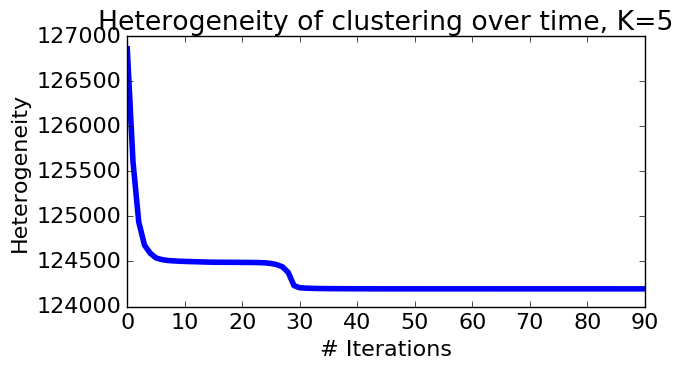

In [77]:
%matplotlib inline
plot_heterogeneity(heterogeneity, k)

In [78]:
centroids

array([[  0.00000000e+00,   1.05469622e-05,   3.71708150e-06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.91948727e-05,   1.52130550e-05,   2.02610389e-05, ...,
          2.64351238e-07,   7.08147156e-03,   2.72742227e-05],
       [  5.60561232e-06,   3.63359293e-06,   6.64154034e-06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.72883925e-05,   7.23459019e-05,   4.63544071e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [79]:
cluster_assignment

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [59]:
documents[2]

' Publicacao \n\n((TITULO))TÍTULO DE NOMEAÇÃO , DE  DE FEVEREIRO DE \n((TEXTO))FERNANDO HADDAD, Prefeito do Município de São Paulo, usando das atribuições que lhe são conferidas por lei,\nRESOLVE:\nNomear o senhor IVES CAMPOS LAZARINI, RF .., para exercer o cargo de Subprefeito, símbolo SBP, da Subprefeitura Butantã, constante das Leis ./ e ./.\nPREFEITURA DO MUNICÍPIO DE SÃO PAULO, aos\xa0\xa0de fevereiro de , ° da fundação de São Paulo. \nFERNANDO HADDAD, Prefeito\n\n((TITULO))TÍTULO DE NOMEAÇÃO , DE  DE FEVEREIRO DE \n((TEXTO))FERNANDO HADDAD, Prefeito do Município de São Paulo, usando das atribuições que lhe são conferidas por lei,\nRESOLVE:\nNomear o senhor RICARDO BRANDÃO FIGUEIREDO, RG ..--SSP/SP, para exercer o cargo de Presidente, símbolo PRE, da Autoridade Municipal de Limpeza Urbana \x96 AMLURB, vinculada à Secretaria Municipal de Serviços.\nPREFEITURA DO MUNICÍPIO DE SÃO PAULO, aos\xa0\xa0de fevereiro de , ° da fundação de São Paulo. \nFERNANDO HADDAD, Prefeito\n\n((TITULO)